<a href="https://colab.research.google.com/github/Polqer/diplommel1/blob/main/Hyperspectral_Vision_Transformer_%222attempt_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install efficientnet-pytorch
!git clone https://github.com/Polqer/diplommel1.git
#!pip install torchcam

fatal: destination path 'diplommel1' already exists and is not an empty directory.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda:0
GPU: Tesla T4
Epoch 0/14
----------
train Loss: 0.1406 Acc: 0.2814
val Loss: 0.0000 Acc: 0.2881
Модель сохранена в /content/diplommel1/checkpoint/best_model.ckpt
Epoch 1/14
----------
train Loss: 0.0000 Acc: 0.2944
val Loss: 0.0000 Acc: 0.2881
Epoch 2/14
----------
train Loss: 0.0000 Acc: 0.2771
val Loss: 0.0000 Acc: 0.2881
Epoch 3/14
----------
train Loss: 0.0000 Acc: 0.3160
val Loss: 0.0000 Acc: 0.2881
Epoch 4/14
----------
train Loss: 0.0000 Acc: 0.2987
val Loss: 0.0000 Acc: 0.2881
Epoch 5/14
----------
train Loss: 0.0000 Acc: 0.2944
val Loss: 0.0000 Acc: 0.2881
Epoch 6/14
----------
train Loss: 0.0000 Acc: 0.3074
val Loss: 0.0000 Acc: 0.2881
Epoch 7/14
----------
train Loss: 0.0000 Acc: 0.3160
val Loss: 0.0000 Acc: 0.2881
Epoch 8/14
----------
train Loss: 0.0000 Acc: 0.3333
val Loss: 0.0000 Acc: 0.2881
Epoch 9/14
----------
train Loss

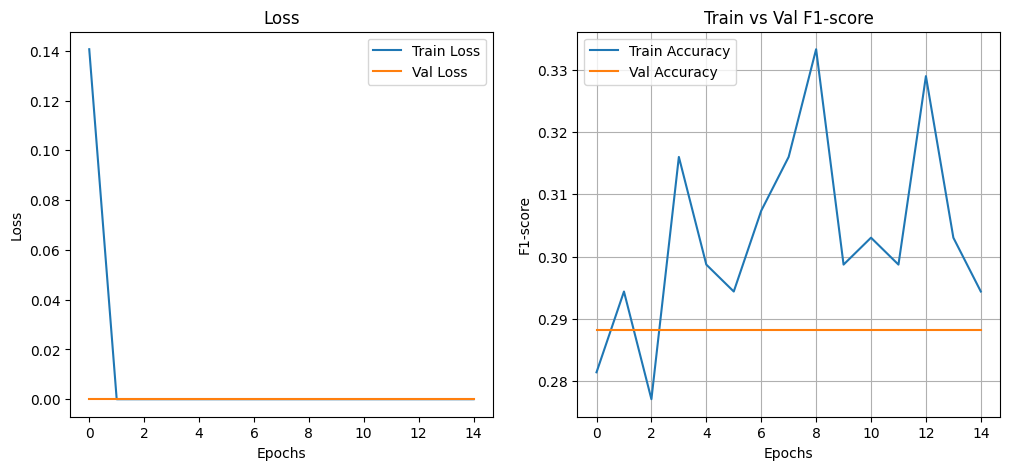

Epoch,▁▁▂▃▃▃▄▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Val Accuracy,█▄▆█▇▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Val Loss,███▇▇▆▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val accuracy,█▄▆█▇▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Val macro/f1,▇▄▆█▆▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val macro/precision,▃▂▂▅█▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val macro/recall,█▃▅█▇▁▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Val micro/f1,█▄▆█▇▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Val micro/precision,█▄▆█▇▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Val micro/recall,█▄▆█▇▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Val micro/roc_auc_score,▅▃▃▄▁▂▂███████████████


In [ ]:
import time
import copy
import torch
import os
import timm
import numpy as np
import torchvision.models as models
import matplotlib.pyplot as plt
import gc
import torch.nn as nn
import wandb
import torch.optim as optim
import torch.nn.functional as F
from scipy.ndimage import zoom
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from scipy.io import loadmat
from pathlib import Path
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from google.colab import drive
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
# Определение устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

drive.mount('/content/drive')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")


train_dir = '/content/diplommel1/datamat/train'
val_dir = '/content/diplommel1/datamat/test'

wandb.init(project="my-awesome-project", name= "matvgg")

batch_size = 8
num_epochs = 15
learning_rate = 0.0001

num_classes = 3  # "mm", "nn", "other"



#т.к. данные являются несбалансированными Focal Loss уменьшает влияние легко классифицируемых примеров и делает модель более чувствительной к сложным случаям
class FocalLoss(nn.Module):
    def __init__(self, gamma=2., alpha=0.25, num_classes=3):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.num_classes = num_classes

    def forward(self, inputs, targets):
        inputs = torch.clamp(inputs, 1e-7, 1 - 1e-7)  # Чтобы избежать логарифмирования 0
        targets = torch.eye(self.num_classes).to(inputs.device).index_select(dim=0, index=targets)  # Преобразуем метки в one-hot
        cross_entropy_loss = -targets * torch.log(inputs)
        loss = self.alpha * torch.pow(1 - inputs, self.gamma) * cross_entropy_loss
        return loss.sum(dim=1).mean()  # Среднее по батчу

class HyperspectralDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(600, 600)):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.target_size = target_size
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.files = []

        for cls_name in self.classes:
            class_dir = self.root_dir / cls_name
            for file_path in class_dir.glob("*.mat"):
                self.files.append((file_path, self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path, label = self.files[idx]
        mat_data = loadmat(file_path)

        if 'DataCubeC' not in mat_data:
            raise KeyError(f"Ключ 'DataCubeC' не найден в файле {file_path}")

        image = mat_data['DataCubeC']  # [H, W, C]
        image = np.transpose(image, (2, 0, 1))  # [C, H, W]

        # Масштабирование изображения
        image_resized = np.zeros((image.shape[0], self.target_size[0], self.target_size[1]))
        for i in range(image.shape[0]):
            image_resized[i, :, :] = zoom(image[i, :, :],
                                          (self.target_size[0] / image.shape[1],
                                           self.target_size[1] / image.shape[2]))

        # Преобразуем в тензор
        image_resized = torch.tensor(image_resized, dtype=torch.float32)  # [C, H, W]

        # Аугментации (если они есть)
        if self.transform:
            image_resized = self.transform(image_resized)

        return image_resized, label  # [C, H, W], int


#Модель с EfficientNet3D EfficientNet предназначен для работы с трёхмерными (3D) данными, например:
# Медицинские изображения (MRI, CT, гиперспектральные кубы) Видео (кадры как временные слои)




# class EfficientNet3D(nn.Module):
#     def __init__(self, num_classes):
#         super(EfficientNet3D, self).__init__()


#         self.model = EfficientNet.from_pretrained('efficientnet-b3')

#         #Изменяем первый слой свертки, чтобы принимать 16 каналов
#         in_channels = 16  #Количество каналов моих гиперспектральных изображениях
#         self.model._conv_stem = nn.Conv2d(in_channels=in_channels,
#                                           out_channels=self.model._conv_stem.out_channels,
#                                           kernel_size=self.model._conv_stem.kernel_size,
#                                           stride=self.model._conv_stem.stride,
#                                           padding=self.model._conv_stem.padding,
#                                           bias=False)

#         #Заменяем последний слой для классификации 3-х классов
#         in_features = self.model._fc.in_features
#         self.model._fc = nn.Linear(in_features, num_classes)

#     def forward(self, x):
#         return self.model(x)



class HyperspectralVisionTransformer(nn.Module):
    def __init__(self, num_classes=3, in_channels=16):
        super(HyperspectralVisionTransformer, self).__init__()

        # Загружаем Vision Transformer (ViT) из библиотеки timm
        self.model = timm.create_model('vit_base_patch16_224', pretrained=True)  # Используем базовую модель ViT

        # Изменяем первый слой для работы с 16 каналами (гиперспектральные данные)
        # В модели ViT первый слой - это Conv2d, который работает с входными изображениями
        self.model.patch_embed.proj = nn.Conv2d(in_channels, self.model.embed_dim, kernel_size=(16, 16), stride=(16, 16))

        # Изменяем последний слой для классификации на 3 класса
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)

    def forward(self, x):
        return self.model(x)


#Расчет метрик
def calculate_metrics(y_true, y_pred, y_true_proba, y_pred_proba):
    return {
        'accuracy': accuracy_score(y_true=y_true, y_pred=y_pred),
        'confusion_matrix': confusion_matrix(y_true=y_true, y_pred=y_pred),
        'micro/precision': precision_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0),
        'micro/recall': recall_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0),
        'micro/f1': f1_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0),
        'micro/roc_auc_score': roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro'),
        'macro/precision': precision_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=0),
        'macro/recall': recall_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=0),
        'macro/f1': f1_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=0),
        'roc_auc_score':  roc_auc_score(y_true=y_true_proba, y_score=y_pred_proba, average=None, multi_class='ovr'),
        'weighted/precision': precision_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=0),
        'weighted/recall': recall_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=0),
        'weighted/f1': f1_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=0)
    }


# Трансформации
transform =  transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Случайное горизонтальное отражение
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Случайные изменения яркости, контраста, насыщенности и оттенка
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),  # Случайные аффинные преобразования: поворот, сдвиг, масштабирование и сдвиг по осям
    transforms.ToTensor(),  # Преобразование изображения в тензор
    transforms.Normalize(mean=[0.5], std=[0.5])  # Нормализация
])


# Загрузка данных
train_dataset = HyperspectralDataset(train_dir, transform=transform, target_size=(320, 320))

val_dataset = HyperspectralDataset(val_dir, transform=transform, target_size=(320, 320))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Инициализация модели
model = HyperspectralVisionTransformer(num_classes=num_classes).to(device)

# Функция потерь и оптимизатор
criterion = FocalLoss(gamma=2.0, alpha=0.25, num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Функция обучения
def train_model(model, criterion, optimizer, num_epochs, checkpoint_dir="/content/diplommel1/checkpoint"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
# Создаём папку для чекпоинтов, если её нет
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, "best_model.ckpt")
    # История обучения
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}\n' + '-' * 10)

        for phase, loader in [('train', train_loader), ('val', val_loader)]:
            is_train = phase == 'train'
            model.train(is_train)

            running_loss = 0.0
            running_corrects = 0

            all_labels, all_preds, all_true_proba, all_pred_proba = [], [], [], []

            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(is_train):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    probabilities = torch.softmax(outputs, dim=1).detach().cpu().numpy()

                    if is_train:
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_true_proba.extend(np.eye(outputs.shape[1])[labels.cpu().numpy()])
                all_pred_proba.extend(probabilities)

            # Средние значения за эпоху
            dataset_size = len(loader.dataset)
            epoch_loss = running_loss / dataset_size
            epoch_acc = (running_corrects.double() / dataset_size).item()

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                # Вычисление метрик
                try:
                    metrics = calculate_metrics(
                        y_true=all_labels,
                        y_pred=all_preds,
                        y_true_proba=np.array(all_true_proba),
                        y_pred_proba=np.array(all_pred_proba)
                    )
                    wandb.log({
                        "Val Loss": epoch_loss,
                        "Val Accuracy": epoch_acc,
                        **{f"Val {k}": v for k, v in metrics.items() if k != 'confusion_matrix'},
                        "Epoch": epoch
                    })
                except Exception as e:
                    print(f"Ошибка при расчете метрик: {e}")

                # Обновление лучшей модели
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    # Сохранение модели в формате .ckpt
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': epoch_loss,
                        'accuracy': epoch_acc
                    }, checkpoint_path)
                    print(f'Модель сохранена в {checkpoint_path}')

        torch.cuda.empty_cache()
        gc.collect()

    # Время обучения
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)

    # Построение графиков
    plt.figure(figsize=(12, 5))

    # График Loss
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label='Train Loss')
    plt.plot(history["val_loss"], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    # График Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label='Train Accuracy')
    plt.plot(history["val_acc"], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')



    return model
# Вызов функции обучения
train_model(model, criterion, optimizer, num_epochs)


plt.xlabel("Epochs")
plt.ylabel("F1-score")
plt.title("Train vs Val F1-score")
plt.legend()
plt.grid(True)
plt.show()
wandb.finish()

In [ ]:
import gc
gc.collect()  # Очистка мусора
torch.cuda.empty_cache()


Попытка использовать Gradcam

Не получается реализовать, либо выдает, что 16 каналов надо 3, при изменениях пишет, что надо каналов 3 получил 16.



In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
import torch.nn as nn
from torchvision import models
from PIL import Image
from scipy.io import loadmat

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_hyperspectral_image(file_path, target_size=(224, 224)):
    mat_data = loadmat(file_path)
    if 'DataCubeC' not in mat_data:
        raise KeyError(f"Ключ 'DataCubeC' не найден в файле {file_path}")

    image = mat_data['DataCubeC']  # Гиперспектральный куб [C, H, W]

    # Масштабирование изображения
    image_resized = np.zeros((image.shape[0], target_size[0], target_size[1]))
    for i in range(image.shape[0]):
        image_resized[i, :, :] = zoom(image[i, :, :],
                                      (target_size[0] / image.shape[1],
                                       target_size[1] / image.shape[2]))

    # Преобразуем в тензор
    image_resized = torch.tensor(image_resized, dtype=torch.float32)  # [C, H, W]
    return image_resized

# Путь к изображению
image_path = '/content/diplommel1/datamat/test/DNcube/100.mat'
image = load_hyperspectral_image(image_path)

# Добавляем размерность батча
image = image.unsqueeze(0).to(device)  # (1, C, H, W)

# Модифицированная модель VGG16 с 16 каналами
class VGG16Custom(nn.Module):
    def __init__(self, num_classes=3, in_channels=16):  # Число классов и количество входных каналов
        super(VGG16Custom, self).__init__()

        # Загружаем предобученную модель VGG-16
        self.model = models.vgg16(pretrained=True)

        # Изменяем первый слой для работы с 16 каналами
        self.model.features[0] = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1)

        # Изменяем последний слой для классификации на 3 класса
        in_features = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Создаём модель
num_classes = 3
in_channels = 16  # Пример для гиперспектральных данных с 16 каналами
model = VGG16Custom(num_classes=num_classes, in_channels=in_channels).to(device)
model.eval()

# Выбираем слой для Grad-CAM
target_layer = model.model.features[29]  # Последний сверточный слой

# Инициализируем Grad-CAM
cam_extractor = GradCAM(model, target_layer=target_layer)

# Пропускаем изображение через модель
output = model(image)
class_idx = output.argmax(dim=1).item()  # Получаем индекс предсказанного класса

# Получаем карту активации
activation_map = cam_extractor(class_idx, output)

# Преобразуем тензоры в numpy
activation_map = activation_map[0].cpu().detach().numpy()

# Для визуализации возьмем среднее значение по всем каналам карты активации
# Нам нужно убедиться, что карта активации имеет правильную форму, чтобы можно было наложить её на изображение
if len(activation_map.shape) == 4:  # Если карта активации имеет лишнюю размерность (например, 4)
    activation_map_2d = np.mean(activation_map, axis=-1)  # Усредняем по последней размерности
else:
    activation_map_2d = activation_map  # Если карта активации уже имеет 3 канала

# Преобразуем изображение для наложения
image_np = image[0].cpu().numpy().transpose(1, 2, 0)  # Преобразуем обратно в [H, W, C]
image_pil = Image.fromarray((image_np * 255).astype(np.uint8))  # Преобразуем в изображение с градациями серого
activation_pil = Image.fromarray((activation_map_2d * 255).astype(np.uint8))  # Преобразуем карту активации в изображение

# Убедимся, что карта активации и изображение имеют одинаковый размер
activation_pil = activation_pil.resize(image_pil.size)

# Накладываем карту активации
overlay = overlay_mask(image_pil.convert("RGB"), activation_pil.convert("RGB"))

# Отображаем результат
plt.imshow(overlay)
plt.axis('off')
plt.show()


RuntimeError: Given groups=1, weight of size [64, 16, 3, 3], expected input[1, 272, 224, 224] to have 16 channels, but got 272 channels instead